#### The formula of atmospheric diabatic heating is proposed by Yanai (1973) 
Yanai, M., Esbensen, S. & Chu, J.-H. Determination of Bulk Properties of Tropical Cloud Clusters from Large-Scale Heat and Moisture Budgets. Journal of the Atmospheric Sciences 30, 611–627 (1973).

In [9]:
import xarray as xr 
from metpy.units import units
import metpy.constants as constants
import metpy.calc as mpcalc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.mpl.ticker as cticker
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from  scipy  import stats
import cmaps
import warnings
warnings.filterwarnings("ignore") 
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.weight"] = "bold"

In [10]:
f_u = xr.open_dataset("/public/home/songqh/my_data/ERA5/monthly/UWND/ERA5-uwnd.nc")
u = f_u.u.loc[f_u.time.dt.month==7,:,f_u.level[3].values:f_u.level[13].values].values[:,0]

f_v = xr.open_dataset("/public/home/songqh/my_data/ERA5/monthly/VWND/ERA5-vwnd.nc")
v = f_v.v.loc[f_v.time.dt.month==7,:,f_v.level[3].values:f_v.level[13].values].values[:,0]

f_w = xr.open_dataset("/public/home/songqh/my_data/ERA5/monthly/OMEGA/ERA5_omega.nc")
w = f_w.w.loc[f_w.time.dt.month==7,f_w.level[3].values:f_w.level[13].values].values[:]

f_t = xr.open_dataset("/public/home/songqh/my_data/ERA5/monthly/TEMPERATURE/ERA5-temp.nc")
t1 = f_t.t.loc[f_t.time.dt.month==8,:,f_t.level[3].values:f_t.level[13].values].values[:,0]
t2 = f_t.t.loc[f_t.time.dt.month==7,:,f_t.level[3].values:f_t.level[13].values].values[:,0]


In [11]:
lon = f_t['longitude'].values
lat = f_t['latitude'].values
lev = f_t['level'].loc[100:1000].values

In [12]:
time = 31*24*60*60*units.s
dTdt = t2*units.K - t1*units.K
#advection
dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)
temadvect = np.zeros((44,11,181,360))
for y in range(44):
    for i in range(11):
        temadvect[y,i,:,:] = mpcalc.advection(t2[y,i], u[y,i], v[y,i],dx=dx, dy=dy,x_dim=-1, y_dim=-2)
temadvect = temadvect * units.K/units.s


In [14]:
#vertical
pressure = np.array(lev).reshape((1,11,1,1))*units.hPa
t_k = t2*units.K
pressure.shape
ss = (constants.dry_air_gas_constant* t_k)/constants.dry_air_spec_heat_press/pressure - np.gradient(t_k,axis=1)/np.gradient(pressure,axis=1)
ver = w*(units.Pa/units.s)*ss

q = ((dTdt - temadvect*time - ver*time)*constants.dry_air_spec_heat_press)/time
#total
total_q = np.trapz(q[:,:],lev[:],axis=1)
total_q.shape


(44, 181, 360)

In [15]:
total_q_mean = np.nanmean(total_q,axis=0)
total_q_2022 = total_q[-1]

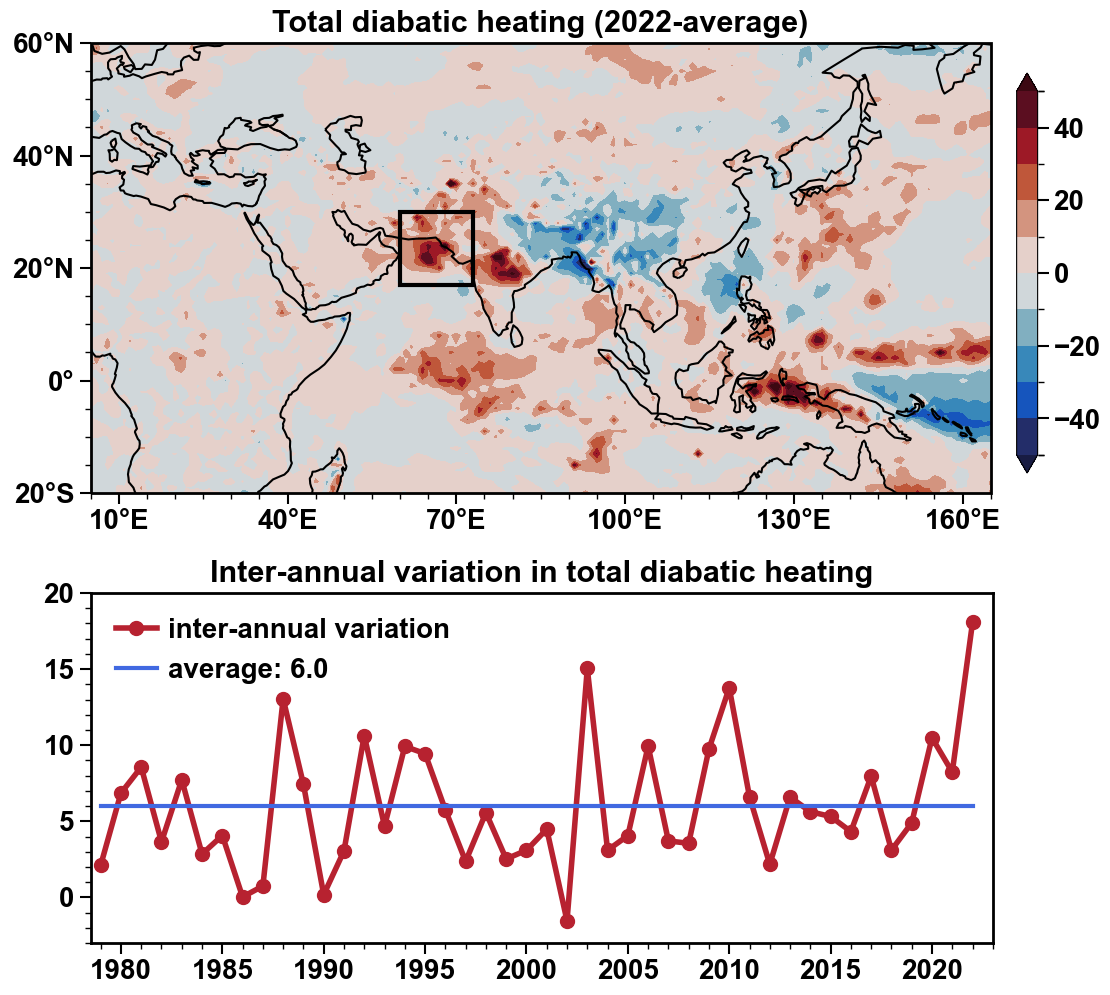

In [16]:

proj = ccrs.PlateCarree(central_longitude=60)
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_axes([0.05,0.5,0.85,0.45],projection = proj)
leftlon, rightlon, lowerlat, upperlat = (5,165,-20,60)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
ax1.set_extent(img_extent, crs=ccrs.PlateCarree())
ax = plt.gca()
ax.spines['geo'].set_linewidth(2)
ax1.tick_params(direction='out', length=8, width=1.5, labelsize=20,axis='both', which='major')
ax1.add_feature(cfeature.LAND.with_scale('110m'),color='lightgray') 
ax1.add_feature(cfeature.COASTLINE.with_scale('110m'),lw=1.5) 
ax1.set_xticks(np.arange(10,180,30), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(lowerlat,upperlat+20,20), crs=ccrs.PlateCarree())
ax1.add_patch(patches.Rectangle([0,17],13,13,linewidth=3,edgecolor='k',facecolor='none',zorder=100))
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.minorticks_on()
ax1.tick_params(which='minor', direction='out', bottom=True, length=4, width=1)
ax1.xaxis.set_minor_locator(plt.MultipleLocator(5))
ax1.yaxis.set_minor_locator(plt.MultipleLocator(5))
ax1.set_title("Total diabatic heating (2022-average)",fontsize=22,weight='bold',loc='center',pad=8)

cf1 = ax1.contourf(lon,lat,total_q_2022 - total_q_mean, zorder=1,levels=np.linspace(-50,50,11),  
                   extend = 'both',transform=ccrs.PlateCarree(), cmap=cmaps.cmocean_balance)
pos = fig.add_axes([0.815,0.52,0.015,0.4])
cb = fig.colorbar(cf1,orientation='vertical',cax=pos)
cb.ax.minorticks_on()
cb.ax.tick_params(which='minor', direction='out', bottom=True, length=4, width=1,labelsize=20)
cb.ax.tick_params(which='major', direction='out', bottom=True, length=8, width=1.5,labelsize=20)
cb.ax.yaxis.set_minor_locator(plt.MultipleLocator(10))

ax2 = fig.add_axes([0.1535,0.05,0.6445,0.35])
ax2.set_ylim(-3,20)
# ax2.set_yticks([-3,-2,-1,0,1,2,3])
ax2.set_xlim(1978.5,2023)
# ax2.text(1980,18,"2022: 18.1",weight='bold',fontsize=22)
ax2.minorticks_on()
ax2.tick_params(which='minor', direction='out', bottom=True, length=4, width=1)
ax2.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(1))
ax2.set_title('Inter-annual variation in total diabatic heating',loc='center',fontsize=22,pad=8,weight='bold')
ax2.tick_params(direction='out', length=8, width=1.5, labelsize=20,axis='both', which='major')
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)
ax2.plot(np.arange(1979,2023),np.nanmean(total_q[:,60:74,60:74],axis=(1,2)),color=[183/255,34/255,48/255],lw=4,marker='o',markersize=10,label='inter-annual variation')
ax2.plot(np.arange(1979,2023),np.full(44,np.nanmean(total_q[:,60:74,60:74],axis=(0,1,2))),color='RoyalBlue',lw=3,label='average: 6.0')
ax2.set_ylabel(" ",fontsize=22)

lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels ,frameon=False,handlelength=1.5,
           handletextpad=0.4,columnspacing=1,fontsize=20,loc='upper left')
# fig.savefig("/public/home/songqh/project/NC_figure/figures/2-Response-7.jpg",dpi=600)
plt.show()

In [17]:
np.nanmean(total_q[:,60:74,60:74],axis=(1,2))

Magnitude,[2.106255741860062 6.852769602353494 8.560736411228621 3.6458525690430896 7.727914893495195 2.849334502020175 4.065456519097773 0.028790269633015307 0.7456385258796375 13.048814676872313 7.435782744143156 0.17454872173978753 3.0504029790338505 10.636185064118544 4.677497170677734 9.920083007495311 9.446874973848468 5.746660903519973 2.369138466951115 5.5648823881994725 2.5261862136795066 3.0952857687842164 4.480483833206525 -1.5409022264208567 15.043653218842685 3.0977102083738712 4.058317691354922 9.943253213216549 3.7097203097373956 3.553469655156563 9.74816359563366 13.76854979988042 6.606994515961215 2.1719430769595216 6.593463744898963 5.628233865459921 5.319446503278132 4.320679391948192 7.964815743785774 3.10620109358538 4.896463755662349 10.488126633786601 8.23069910930527 18.072582449553913]
Units,joule/(kilogram second)


In [18]:
lat[60:74]

array([30., 29., 28., 27., 26., 25., 24., 23., 22., 21., 20., 19., 18.,
       17.], dtype=float32)

In [19]:
print(np.nanmean(total_q[-1,60:74,60:74],axis=(0,1)))
print(np.nanmean(total_q[:,60:74,60:74],axis=(0,1,2)))

18.072582449553913 joule / kilogram / second
5.98948093856458 joule / kilogram / second


In [21]:
pre_ism = np.loadtxt("/public/home/songqh/my_data/project/MHW_2022/pre_ism.txt")
elate_index = np.loadtxt("/public/home/songqh/my_data/project/MHW_2022/elate_index.txt")
ah = np.nanmean(total_q[:,60:74,60:74],axis=(1,2))
r1,p1 = stats.pearsonr(pre_ism,ah)
r2,p2 = stats.pearsonr(elate_index,ah)
print(r1,r2,p1,p2)

0.9305892850077004 0.9567645722490765 6.122126952267633e-20 3.810332180947173e-24
